In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

c:\Users\21lyb\Documents\CSCB-2025-Final\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Package,Version
numpy,1.26.4
pandas,2.2.3
scanpy,1.11.1
infercnvpy,0.6.0
matplotlib,3.10.0
biomart,0.9.2
anndata,0.11.4
scikit-learn,1.5.2
Component,Info
Python,"3.11.6 | packaged by conda-forge | (main, Oct 3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]"


In [ ]:
# Functions
def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_ids','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_ids'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def preprocess(adata,
               min_mean=0.0125,
               max_mean=6,
               min_disp=0.25):
    
    adNorm = adata.copy()

    # Normalize and log transform
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adata, use_highly_variable=True)
    # sc.pl.pca_variance_ratio(adata,50)

    return adNorm

def KNN(adata, n_neighbors=20, n_pcs=10, annotation="cell_type"):
    sc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=annotation)

def downsample(adata,n_cells):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()

def extract_cnv_info(cnv_annotation):
    if cnv_annotation:
        parts = cnv_annotation.split(" ")
        if len(parts) > 1:
            cnv_chr = parts[0].split(":")[0]
            cnv_start = parts[0].split(':')[1].split('-')[0]
            cnv_end = parts[0].split(':')[1].split('-')[1]
            cnv_type = parts[-1].strip("()")
            return cnv_chr,cnv_start,cnv_end,cnv_type
    return None, None

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
# Run if needed:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

In [7]:
adata = fetch_positions(adata)

Request successful!


In [8]:
adata = standardize_chromosomes(adata)

In [9]:
adata = preprocess(adata)

In [ ]:
# KNN(adata,n_pcs=10)

In [ ]:
# Insert CopyKAT GMM clustering here to find diploid vs aneuploid cell types

In [78]:
# Convolution to find windows of aberrant gene expression for each chromosome
# for aneuploid cell types
def convolve(adata,annotation='cell_type',aneuploid_cell_type='',window_size=1000,step_size=100,fold_change_threshold=1.8):

    # Filter adata to only aneuploid cell type
    adata_aneuploid = adata.copy()
    if len(adata_aneuploid) != 0:
        adata_aneuploid = adata_aneuploid[adata_aneuploid.obs[annotation]==aneuploid_cell_type].copy()
    
    # Sort by chromosomes and positions
    var_sorted_all = adata.var.sort_values(by=['chromosome','start'])
    var_sorted_aneuploid = adata_aneuploid.var.sort_values(by=['chromosome','start'])
    adata_sorted_all = adata[:,var_sorted_all.index].copy()
    adata_sorted_aneuploid = adata_aneuploid[:,var_sorted_aneuploid.index].copy()

    # Smoothed gene expression matrix through sliding window mean
    smoothed_matrix = np.vstack([
        sliding_window_mean(expr_df.iloc[i].values, window_size, step_size)
        for i in range(expr_df.shape[0])
    ])



    
def sliding_window_mean(arr,window_size,step):
    if arr.shape[1] < window_size:
        return np.array([])
    n_windows = (arr.shape[1] - window_size) // step + 1
    result = np.empty((arr.shape[0],n_windows))

    for i in range(n_windows):
        start = i*step
        end = start + window_size
        result[:,i] = arr[:,start:end].mean(axis=1)

    return result


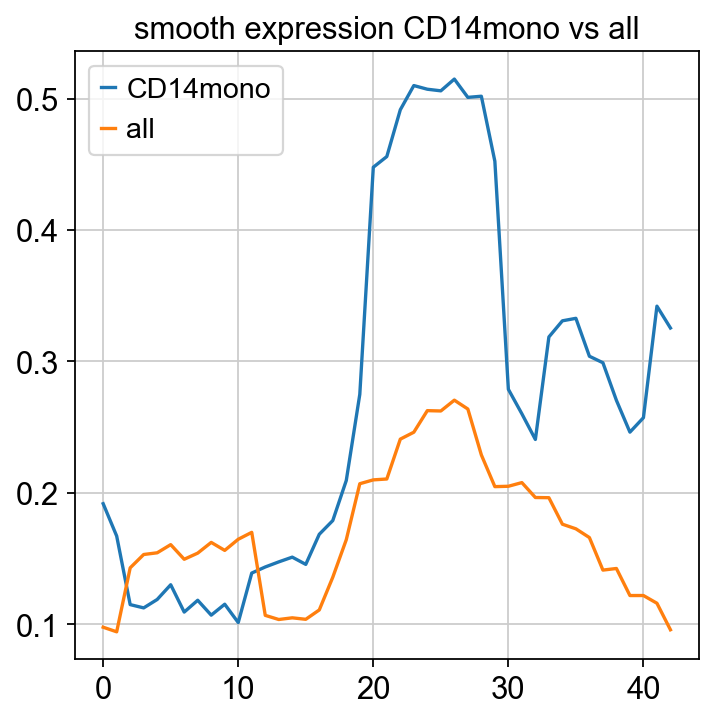

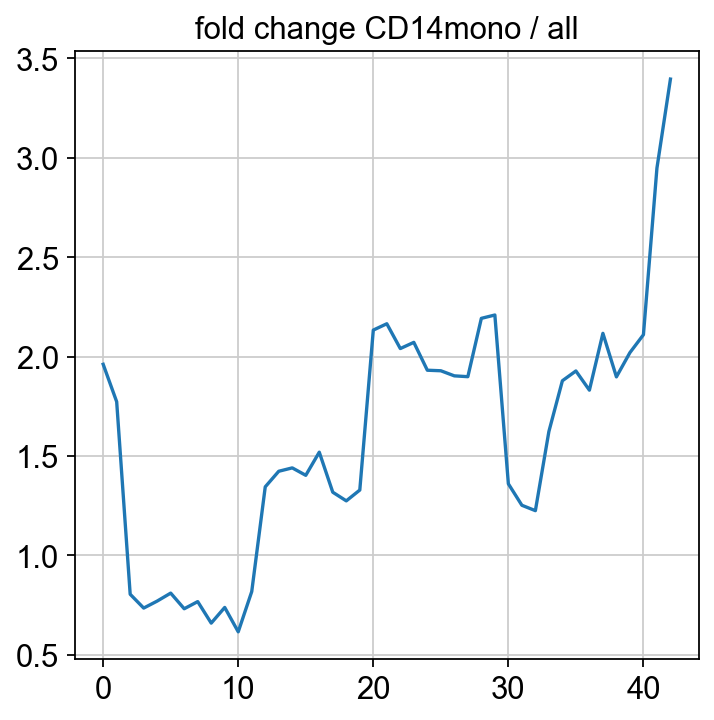

In [168]:
chr = 'chr22'
window_size = 100
step_size = 10

adata_sorted_aneuploid_22 = adata_sorted_aneuploid[:,adata_sorted_aneuploid.var['chromosome'].isin([chr])]
adata_sorted_all_22 = adata_sorted_all[:,adata_sorted_all.var['chromosome'].isin([chr])]

arr_aneuploid = sliding_window_mean(adata_sorted_aneuploid_22.X.toarray(),window_size,step_size)
arr_all = sliding_window_mean(adata_sorted_all_22.X.toarray(),window_size,step_size)
t = np.arange(arr_all.shape[1])

cell_means_aneuploid = arr_aneuploid.mean(axis=0)
cell_means_all = arr_all.mean(axis=0)

plt.plot(t,cell_means_aneuploid,label='CD14mono')
plt.plot(t,cell_means_all,label='all')
plt.legend()
plt.title('smooth expression CD14mono vs all')
plt.show()

plt.plot(t,cell_means_aneuploid/cell_means_all)
plt.title('fold change CD14mono / all')
plt.show()

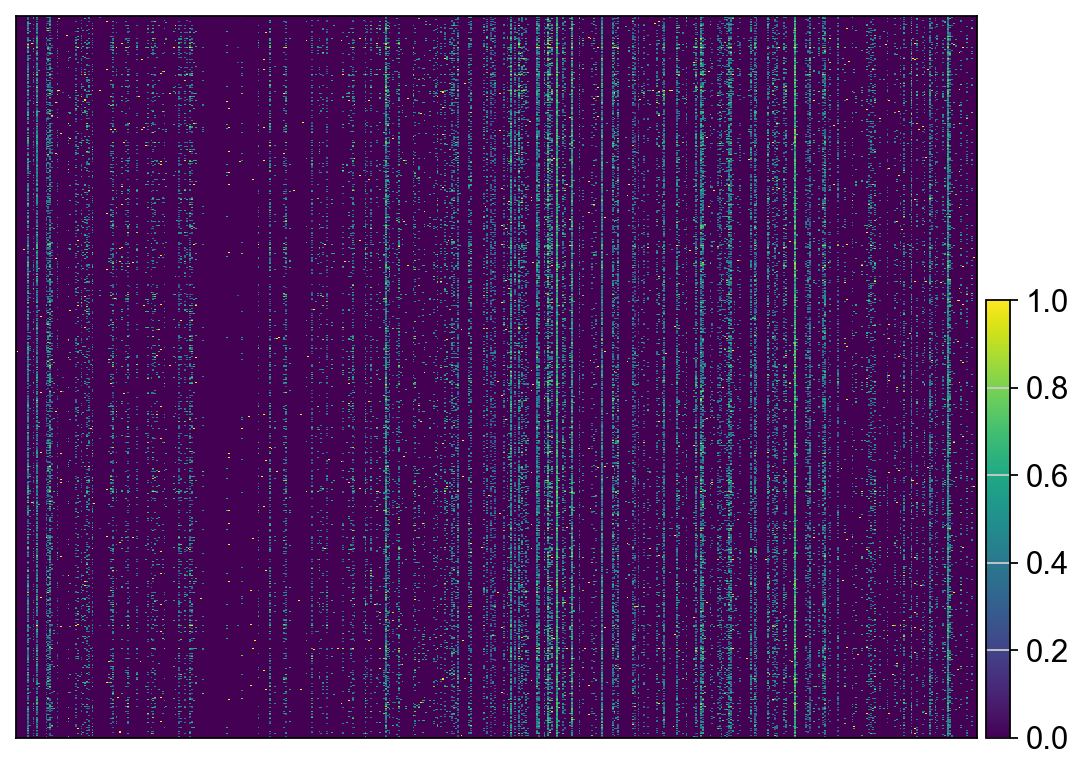

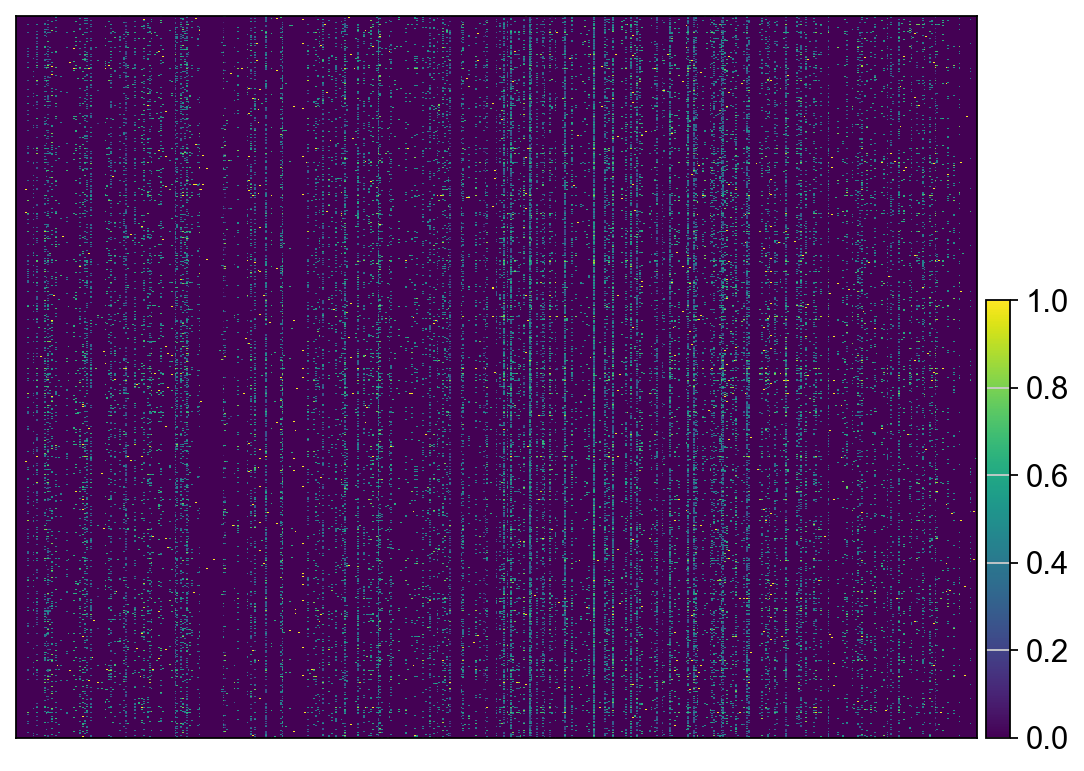

In [163]:
# get slice of cd14 monocytes and Chr22
adMono = adata_sorted_aneuploid
adChr22 = adMono[:,adMono.var['chromosome']=='chr22'].copy()
# Raw counts on left
# sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs',layer="counts", log=True)
# gene-scaled on right makes the CNA footprint more apparent
sc.pl.heatmap(adChr22, adChr22.var_names,groupby='cell_type',layer="counts", log=True, standard_scale='var')

# get slice of cd14 monocytes and Chr22
adMono = adata_sorted_all
adChr22 = adMono[:,adMono.var['chromosome']=='chr22'].copy()
# Raw counts on left
# sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs',layer="counts", log=True)
# gene-scaled on right makes the CNA footprint more apparent
sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs',layer="counts", log=True, standard_scale='var')